In [1]:
# use this to hide the red warning boxes
# Only use once you know they aren't significant
import warnings
warnings.filterwarnings('ignore')

# Basic burden testing
Perform burden testing to identify genes with variants occuring at significantly higher rates in patients with a history of recurrent miscarriages vs. those without.

## Previous processing

### Removing netural variation

*(05_Filter_variant_data/variant_data_processing.ipynb)*

 * Changed genotype from VCF-style (e.g. 0/1, 1/1, ./., etc.) to a single number
  * 0 for nothing detected or uncertain
  * 1 for heterozygous or het/uncertain
  * 2 for homozygous
  * Any other values set to NaN (Original VCFs had split multiallelic variants, so there should be no 0/2 etc.)

 1. Removed duplicates of the same variant from the same sample
  * Interested in maternal variants, so removed duplicates with same varint ID and maternal ID
  * This happens because some mothers had multiple children in the study and appeared duplicated for each trio.
 2. Removed maternal variants with "uncertain" genotype (only ./., left any with at least one allele called)
 3. Removed any variants not found in maternal samples (e.g. mat genotype = 0/0) - this was only a very small number
 4. Removed all variants with >5% AF in GnomAD (as annotated with VEP during an earlier step)
 5. Removed any variants with a VEP predicted functional class of "MODIFIER"
 6. Removed any variants with a VEP predicted functional class of "LOW"
  * These two steps effectively removed any variants predicted not to be protein altering - leaving missense, indels, splicing, etc.
 
Approx variant numbers remaining after each step:
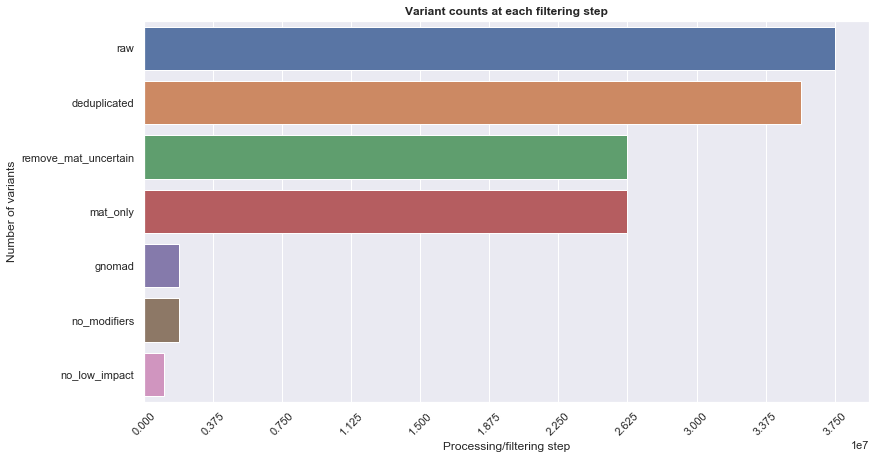

### Checking allele frequencies - GnomAD vs. cohort

*(05_Filter_variant_data/variant_data_processing.ipynb)*

The frequency of each variant within this cohort was calculated (based on allele count and total chromosome count). This could then be compared against the AF in GnomAD, to see if there were any large differences from the expected values that might suggest a problem (some variants are not present in GnomAD). The vast majority of variants are very close to the expected frequencies.

This could be investigated further if needed, but I suspect that the largest differences are probably due to the smaller sample size, and may also indicated technical artefacts that have not been successfully filtered out.

**NOTE:** The axes in this plot have different scales - the red diagonal line shows the 1:1 ratio.

Observed cohort AF vs. expected GnomAD AF:
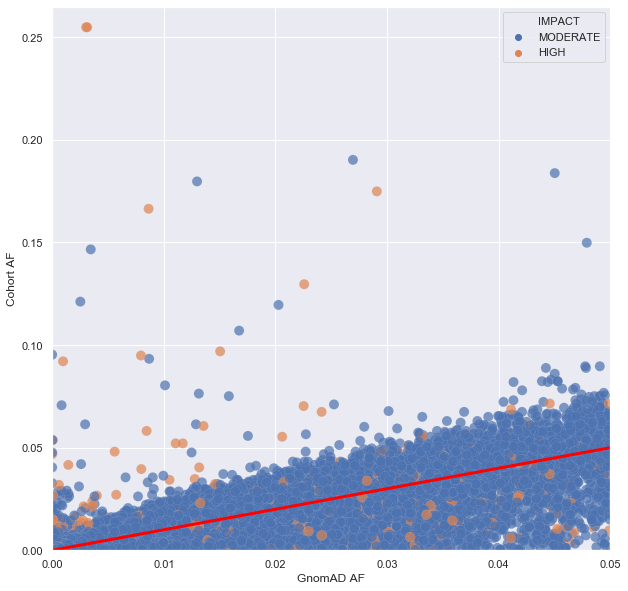

### Combining variant and phenotype data

*06_Process_phenotype_data/phenotype_csv_processing.ipynb*

Prepared the phenotype data (which was stored in a separate Excel file, vs. variant information in individual sample VCFs) to be merged with the variant data - so you can easily look up the phenotype associated with a patient who has a particualr variant.

 * Checked that key categorical data columns had no duplicate values (e.g. different capitalisation, spelling mistakes, etc). Ensured that all pregnancy_loss_history values were consistent (e.g 1, 'one', or 'One' -> 1).
 * Plotted a few of the numeric columns to check that there were no obvious incorrect values or extreme outliers (e.g. maternal age, birthweight, all had missing values or some that were improbable)

Pregnancy loss data, highlighting fairly minor impact of maternal age:
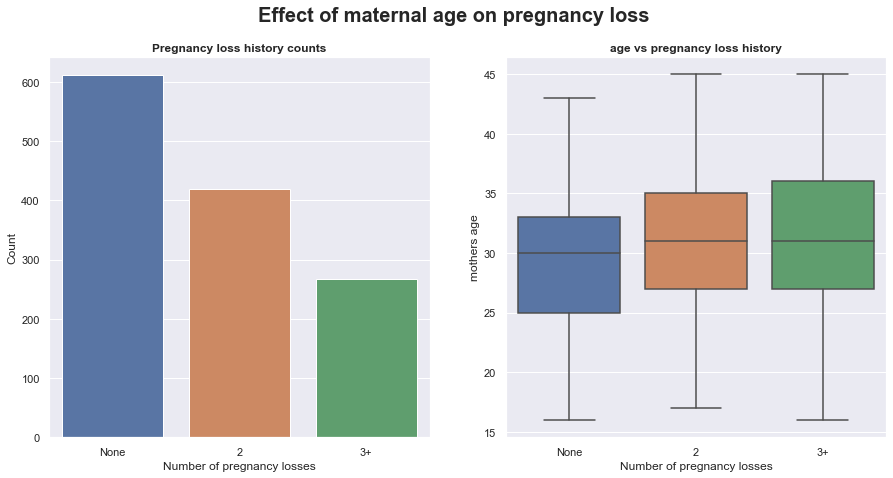

## Initial data loading

The main dataset generated by previous processing is around 800Mb, so to facilitate sharing a trimmed version retaining only the relevant information. This reduces the total size of the saved data to 40Mb, which is much more practical.

The dataframe contains a row for each variant in each sample (e.g. variants in multiple patients occur multiple times - one per patient). Only those variants which occur in a maternal sample are retained, which further removes unnecessary data.

The columns for gene name, variant ID, mothers DDD ID, the variant count (1 for heterozygous, 2 for homozygous), and the pregnancy loss history are kept. Other data (including a large amount of phenotype information) are removed, but remain available in the full version of the dataset.

In [2]:
import pandas as pd
import scipy.stats as stats
import sys
import sklearn.datasets
import sklearn.decomposition
import seaborn as sns
# Make Matplotlib plots appear inline
%matplotlib inline

pd.options.display.max_columns = 999

In [3]:
# Load the smaller trimmed dataframe if it's available
try:
    df_joined = pd.read_pickle("Processed_data/Trimmed_variant_data.pickle")
    print("Loaded trimmed variant data from file", file=sys.stderr)
except FileNotFoundError:
    # Load the processed data from the previous step
    df_joined = pd.read_pickle('../07_Var_pheno_mapping/Processed_data/variant_phenotype_merged.pickle')
    df_joined = df_joined[['GENE', 'ID', 'MAT_ID', 'MAT_GT', 'pregnancy_loss_history']]
    df_joined.to_pickle("Processed_data/Trimmed_variant_data.pickle")
    print("Loaded full data from file, and saved trimmed data", file=sys.stderr)

Loaded trimmed variant data from file


## splitting cases and controls

The DDD dataset reports numbers of prior miscarriages in 3 groups - "None", "2", and "3+". It is not clear what happens to women with a single previous miscarriages, but I assume these have been grouped with "None" as it is not indicative of recurre t pregnancy losses. 

To get the clearest possible differene between cases and the control group, the "2" pregnancy losses group is being discounted. The "None" group is used for controls, while the "3+" groups are the cases.

To record how many samples are in each group, the number of unique maternal IDs is counted. Larger numbers are better to provide more statistical power. It is probably not viable to use a public dataset such as GnomAD to boost the numbers of control samples, as this does not include the relevant information about previous pregnancy losses.

***Is there a good way of calculating the statistical power of a burden test based on the sample numbers?***

In [4]:
df_cases = df_joined[df_joined.pregnancy_loss_history == "3+"]
df_controls = df_joined[df_joined.pregnancy_loss_history == "None"]

ctrl_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["None"]
case_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["3+"]
discarded_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["2"]

print(f"Total number of cases: {case_count}", file=sys.stderr)
print(f"Total number of controls: {ctrl_count}", file=sys.stderr)
print(f"Discarded samples: {discarded_count}", file=sys.stderr)

Total number of cases: 249
Total number of controls: 588
Discarded samples: 401


## Test running

[Guo et al (2018)](https://pubmed.ncbi.nlm.nih.gov/30269813/) suggests that burden testing follows these steps:

1. For each gene, count how many samples have at least 1 or 2 variants (depending on dominant or recessive model), and how many do not.
2. For each gene, make a confusion matrix of samples with and without variants for both controls and cases:

|          | >=n variants | <n variants |
|----------|--------------|-------------|
| Cases    |       a      |      b      |
| Controls |       c      |      d      |

3. Calculate Fishers exact to get a p-value for each gene
4. Identify those with a significant score (***??Does there need to be a correction applied??***)



Burden tests *may* have difficulties if some variants are non-causal (which seems to me to make them pretty much useless? Most variants are non-causal for the trait you're interested in) (https://www.uab.edu/medicine/rheumatology/images/09112014.pdf). SKAT test might be a better option? SKAT-O combines SKAT and burden tests.

In [5]:
def count_samples_with_variants(target_gene, dataframe):
    """Count how many samples in the given dataframe have at least 1 variant in the specified gene
    
    This can be modified to only count samples with variants matching particular modes of inheritence
    e.g. We can only count 
    """
    # subset the target dataframe to get only this gene
    temp_df = dataframe[dataframe.GENE == target_gene]
    # set MAT_COUNT == 2 and final == 1 to capture exclusively homozygous variants
    # set the final >= 1 to 2 (with MAT_COUNT >=1) to require at least a compound het, including hom
    # MAT_COUNT >=1 and .count == 1 should get single dominant variants
    # Currently, we are counting one or more variants
    temp_df_2 = temp_df[temp_df.MAT_GT >= 1].groupby("MAT_ID")[['MAT_GT']].count() >= 1
    
    # Return the number of samples in which the above criteria is matched
    answer = len(temp_df_2[temp_df_2.MAT_GT == True])
    
    # clear temp dataframes
    del(temp_df)
    del(temp_df_2)
    
    return answer


def do_burden_test(row):
    """Do a Fisher exact test on the case/control positive/negative counts"""
    cases = [row.loc['pos_cases'], row.loc['neg_cases']]
    controls = [row.loc['pos_controls'], row.loc['neg_controls']]
    # Use Scipy.stats fisher exact test
    # Order doesn't seem to matter as long as they are grouped correctly
    oddsratio, pvalue = stats.fisher_exact([cases, controls])
    
    if oddsratio < 1:
        # This will stop "protective" genes from appearing
        # They might be interesting, but they aren't relevant for now
        return 1
    return pvalue

In [6]:
%%time
try:
    burden_test = pd.read_pickle("Processed_data/burden_test_results.pickle")
except FileNotFoundError:
    burden_test = pd.DataFrame(columns=['GENE'])
    # get a list of all genes (need to cast to object type)
    burden_test['GENE'] = sorted(df_joined.GENE.astype("object").unique())

    # Have to use .insert() to add each column, otherwise I was getting a warning.
    burden_test.insert(1, "total_controls", df_controls.MAT_ID.unique().shape[0])
    burden_test.insert(2, "pos_controls", burden_test.GENE.apply(count_samples_with_variants, args=(df_controls,)))
    burden_test.insert(3, "neg_controls", burden_test["total_controls"] - burden_test["pos_controls"])
    burden_test.insert(4, "total_cases", df_cases.MAT_ID.unique().shape[0])
    burden_test.insert(5, "pos_cases", burden_test.GENE.apply(count_samples_with_variants, args=(df_cases,)))
    burden_test.insert(6, "neg_cases", burden_test["total_cases"] - burden_test["pos_cases"])

    burden_test.insert(7, 'pval', burden_test.apply(do_burden_test, axis=1))
    
    #burden_test.to_pickle("Processed_data/burden_test_results.pickle")

print(f"Number of genes tested: {burden_test.shape[0]}", file=sys.stderr)

print(f"Genes with p <= 0.05: {burden_test[burden_test.pval <= 0.05].shape[0]}", file=sys.stderr)    

burden_test.sort_values('pval', ascending=True).head(25)

Wall time: 1min 49s


Number of genes tested: 18234
Genes with p <= 0.05: 287


GENE  total_controls  pos_controls  neg_controls  total_cases  \
7597     INO80E             588             1           587          249   
12446    PRSS55             588            36           552          249   
3051      CELF2             588             0           588          249   
13647    SAMD9L             588            66           522          249   
1669     BPIFB3             588            12           576          249   
3911       CTU2             588            27           561          249   
12301     PRIM1             588             7           581          249   
3486    CNTNAP2             588             9           579          249   
5346    FAM186A             588            67           521          249   
7770      ITPR2             588            51           537          249   
7134   HSD17B13             588            59           529          249   
3643      CPED1             588            27           561          249   
8215      KLK13             588            24           564          249   
13418       RPE             588             1           587          249   
6675     GTF3C5             588            22           566          249   
2382      CABP2             588             3           585          249   
2403     CACNB1             588             3           585          249   
6271      GLIS2             588            53           535          249   
3976   CYB561D2             588             2           586          249   
7458     IGSF11             588             2           586          249   
12298  PRICKLE2             588             2           586          249   
1499      BAZ2B             588            44           544          249   
15534    TCF7L1             588            83           505          249   
16755   TUBGCP6             588           106           482          249   
15257     SYCE2             588             8           580          249   

       pos_cases  neg_cases      pval  
7597           9        240  0.000122  
12446         34        215  0.000564  
3051           6        243  0.000664  
13647         50        199  0.000990  
1669          17        232  0.001344  
3911          27        222  0.001766  
12301         13        236  0.001800  
3486          14        235  0.001918  
5346          49        200  0.002108  
7770          40        209  0.002322  
7134          44        205  0.002735  
3643          26        223  0.002782  
8215          24        225  0.002960  
13418          6        243  0.003484  
6675          22        227  0.003763  
2382           8        241  0.003824  
2403           8        241  0.003824  
6271          40        209  0.003850  
3976           7        242  0.003885  
7458           7        242  0.003885  
12298          7        242  0.003885  
1499          35        214  0.004229  
15534         56        193  0.004290  
16755         67        182  0.004982  
15257         12        237  0.005088